# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

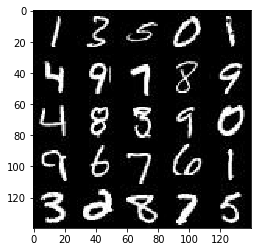

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join('./data', 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

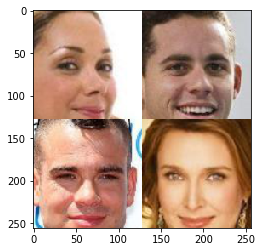

In [17]:
show_n_images = 4

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir,'img_align_celeba/*.jpg'))[:show_n_images], 128, 128, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name='input_real')
    input_z =tf.placeholder(tf.float32, (None, z_dim) , name='input_z')
    lr = tf.placeholder(tf.float32,  name ='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
alpha = 0.01
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_size=4
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same' )
        x1 = tf.maximum(alpha*x1, x1)
        #16*16*64
#         print(x1.shape)
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides=2, padding='same' )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #8*8*128
#         print(x2.shape)
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides=2, padding='same' )
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #4*4*256
#         print(x3.shape)
        
        flats = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense( flats, 1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
alpha=0.2
keep_prob=0.75
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_size=4
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1=tf.layers.dense(z, 7*7*512)
        x1=tf.reshape(x1, [-1,7,7,512])
        x1=tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x1",x1.shape)
        x2=tf.layers.conv2d_transpose(x1, 128, kernel_size, strides=2, padding='same')
        x2=tf.layers.batch_normalization(x2, training=is_train)
        x2=tf.maximum(alpha * x2, x2)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x2",x2.shape)
        x3=tf.layers.conv2d_transpose(x2, 32, kernel_size, strides=2, padding='same')
        x3=tf.layers.batch_normalization(x3, training=is_train)
        x3=tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        print("x3",x3.shape)
        
#         x4=tf.layers.conv2d_transpose(x3, 8, 5, strides=2, padding='same')
#         x4=tf.layers.batch_normalization(x4, training=is_train)
#         x4=tf.maximum(alpha * x4, x4)
#         print("x4",x4.shape)
        # Output layer, 28*28*3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same')
#         logits=tf.reshape(logits, [-1,28,28,out_channel_dim])
        print("logits",logits.shape)
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model =  generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss= d_loss_real+d_loss_fake
    g_loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)) )
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images", len(batch_images))
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images=batch_images*2 #learned this trick from the Udacity forum!
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)
Epoch 0/3... Discriminator Loss: 0.4021... Generator Loss: 2.9818
Epoch 0/3... Discriminator Loss: 0.3835... Generator Loss: 3.3904
Epoch 0/3... Discriminator Loss: 0.3470... Generator Loss: 4.7265
Epoch 0/3... Discriminator Loss: 0.3881... Generator Loss: 4.2219
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


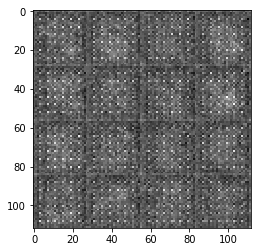

Epoch 0/3... Discriminator Loss: 0.3951... Generator Loss: 6.4918
Epoch 0/3... Discriminator Loss: 0.5444... Generator Loss: 5.0702
Epoch 0/3... Discriminator Loss: 1.2863... Generator Loss: 1.5033
Epoch 0/3... Discriminator Loss: 0.8655... Generator Loss: 1.8029
Epoch 0/3... Discriminator Loss: 0.7929... Generator Loss: 2.5973
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


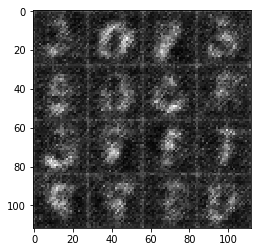

Epoch 0/3... Discriminator Loss: 1.1712... Generator Loss: 0.7777
Epoch 0/3... Discriminator Loss: 0.8482... Generator Loss: 1.3626
Epoch 0/3... Discriminator Loss: 0.8655... Generator Loss: 2.0032
Epoch 0/3... Discriminator Loss: 0.7919... Generator Loss: 2.1190
Epoch 0/3... Discriminator Loss: 1.1983... Generator Loss: 0.7358
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


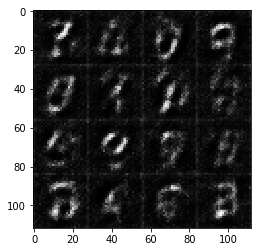

Epoch 0/3... Discriminator Loss: 1.1457... Generator Loss: 0.7055
Epoch 0/3... Discriminator Loss: 0.7673... Generator Loss: 1.4026
Epoch 0/3... Discriminator Loss: 0.8518... Generator Loss: 1.2352
Epoch 0/3... Discriminator Loss: 0.9070... Generator Loss: 1.8567
Epoch 0/3... Discriminator Loss: 0.9028... Generator Loss: 0.9799
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


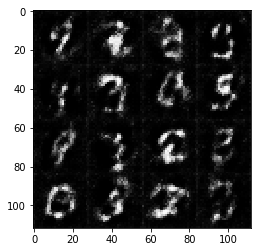

Epoch 0/3... Discriminator Loss: 0.7135... Generator Loss: 1.7518
Epoch 0/3... Discriminator Loss: 0.9098... Generator Loss: 2.3322
Epoch 0/3... Discriminator Loss: 0.7075... Generator Loss: 1.4728
Epoch 0/3... Discriminator Loss: 0.7154... Generator Loss: 2.0825
Epoch 0/3... Discriminator Loss: 0.6347... Generator Loss: 2.2961
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


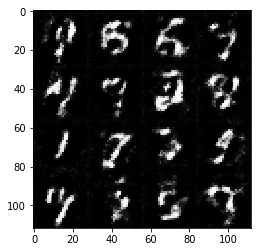

Epoch 0/3... Discriminator Loss: 0.6727... Generator Loss: 1.5582
Epoch 0/3... Discriminator Loss: 0.8115... Generator Loss: 1.1769
Epoch 0/3... Discriminator Loss: 0.6656... Generator Loss: 1.5796
Epoch 0/3... Discriminator Loss: 0.5988... Generator Loss: 1.8435
Epoch 0/3... Discriminator Loss: 0.5836... Generator Loss: 1.9280
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


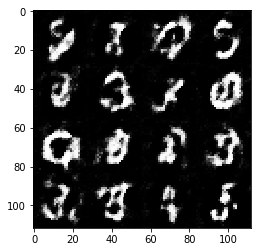

Epoch 0/3... Discriminator Loss: 0.7430... Generator Loss: 1.2984
Epoch 0/3... Discriminator Loss: 0.6174... Generator Loss: 2.1707
Epoch 0/3... Discriminator Loss: 0.6322... Generator Loss: 1.6781
Epoch 0/3... Discriminator Loss: 1.2681... Generator Loss: 3.6045
Epoch 0/3... Discriminator Loss: 0.6653... Generator Loss: 1.5107
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


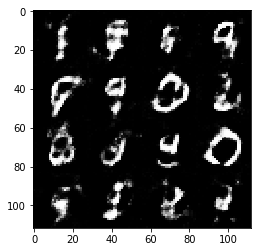

Epoch 0/3... Discriminator Loss: 0.6675... Generator Loss: 2.7707
Epoch 0/3... Discriminator Loss: 0.6200... Generator Loss: 2.0408
Epoch 0/3... Discriminator Loss: 0.6835... Generator Loss: 1.6781
Epoch 0/3... Discriminator Loss: 0.6214... Generator Loss: 1.9777
Epoch 0/3... Discriminator Loss: 0.7255... Generator Loss: 1.3850
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


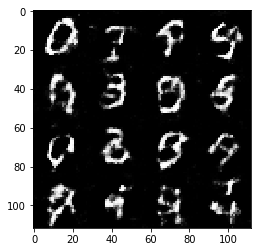

Epoch 0/3... Discriminator Loss: 0.7935... Generator Loss: 2.4024
Epoch 0/3... Discriminator Loss: 0.8341... Generator Loss: 1.1757
Epoch 0/3... Discriminator Loss: 0.7596... Generator Loss: 1.5386
Epoch 0/3... Discriminator Loss: 0.7407... Generator Loss: 1.4975
Epoch 0/3... Discriminator Loss: 0.7351... Generator Loss: 1.7205
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


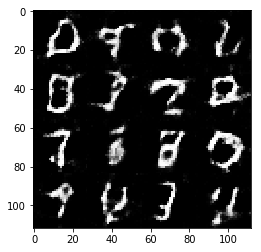

Epoch 0/3... Discriminator Loss: 0.8129... Generator Loss: 1.2023
Epoch 0/3... Discriminator Loss: 0.7256... Generator Loss: 1.6664
Epoch 1/3... Discriminator Loss: 0.7701... Generator Loss: 1.5930
Epoch 1/3... Discriminator Loss: 0.9341... Generator Loss: 0.8820
Epoch 1/3... Discriminator Loss: 0.8908... Generator Loss: 1.0353
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


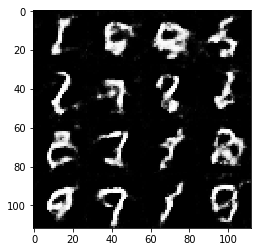

Epoch 1/3... Discriminator Loss: 0.7674... Generator Loss: 1.3419
Epoch 1/3... Discriminator Loss: 0.7246... Generator Loss: 2.2338
Epoch 1/3... Discriminator Loss: 0.8447... Generator Loss: 1.2866
Epoch 1/3... Discriminator Loss: 0.8048... Generator Loss: 1.8523
Epoch 1/3... Discriminator Loss: 0.8070... Generator Loss: 2.3078
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


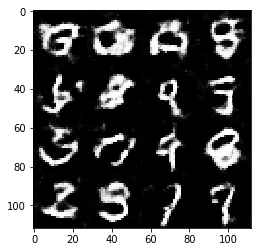

Epoch 1/3... Discriminator Loss: 0.7646... Generator Loss: 1.2031
Epoch 1/3... Discriminator Loss: 0.8105... Generator Loss: 1.2547
Epoch 1/3... Discriminator Loss: 0.7499... Generator Loss: 1.9518
Epoch 1/3... Discriminator Loss: 0.7416... Generator Loss: 2.3701
Epoch 1/3... Discriminator Loss: 0.7524... Generator Loss: 1.4042
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


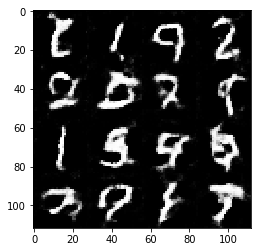

Epoch 1/3... Discriminator Loss: 1.0771... Generator Loss: 2.7777
Epoch 1/3... Discriminator Loss: 0.7720... Generator Loss: 2.0210
Epoch 1/3... Discriminator Loss: 0.7861... Generator Loss: 1.2569
Epoch 1/3... Discriminator Loss: 0.7344... Generator Loss: 1.4813
Epoch 1/3... Discriminator Loss: 0.8211... Generator Loss: 1.1046
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


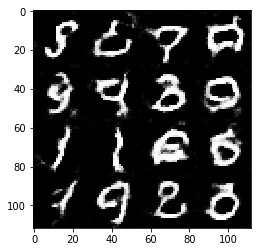

Epoch 1/3... Discriminator Loss: 1.0101... Generator Loss: 0.8493
Epoch 1/3... Discriminator Loss: 0.7610... Generator Loss: 1.5831
Epoch 1/3... Discriminator Loss: 1.3985... Generator Loss: 3.3874
Epoch 1/3... Discriminator Loss: 1.0497... Generator Loss: 0.8065
Epoch 1/3... Discriminator Loss: 0.7083... Generator Loss: 1.5733
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


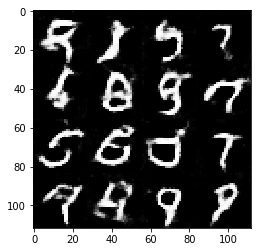

Epoch 1/3... Discriminator Loss: 0.7423... Generator Loss: 1.8279
Epoch 1/3... Discriminator Loss: 0.8526... Generator Loss: 2.3271
Epoch 1/3... Discriminator Loss: 0.7698... Generator Loss: 1.9237
Epoch 1/3... Discriminator Loss: 0.7589... Generator Loss: 2.0689
Epoch 1/3... Discriminator Loss: 0.8589... Generator Loss: 2.3912
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


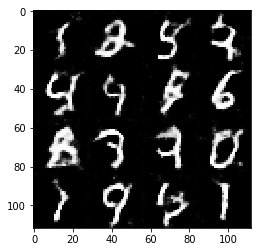

Epoch 1/3... Discriminator Loss: 0.9372... Generator Loss: 0.9862
Epoch 1/3... Discriminator Loss: 0.7841... Generator Loss: 1.6193
Epoch 1/3... Discriminator Loss: 0.7382... Generator Loss: 1.9780
Epoch 1/3... Discriminator Loss: 1.0305... Generator Loss: 0.8818
Epoch 1/3... Discriminator Loss: 0.6900... Generator Loss: 1.7095
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


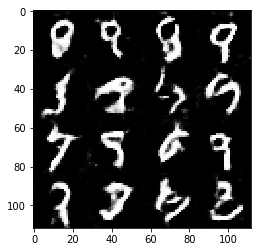

Epoch 1/3... Discriminator Loss: 0.8319... Generator Loss: 1.3113
Epoch 1/3... Discriminator Loss: 0.8071... Generator Loss: 1.1738
Epoch 1/3... Discriminator Loss: 0.7989... Generator Loss: 1.5628
Epoch 1/3... Discriminator Loss: 0.7790... Generator Loss: 1.2293
Epoch 1/3... Discriminator Loss: 0.6531... Generator Loss: 1.9398
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


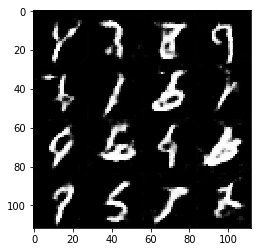

Epoch 1/3... Discriminator Loss: 0.6786... Generator Loss: 1.7688
Epoch 1/3... Discriminator Loss: 0.6571... Generator Loss: 1.5899
Epoch 1/3... Discriminator Loss: 0.7467... Generator Loss: 1.6513
Epoch 1/3... Discriminator Loss: 0.6812... Generator Loss: 1.9620
Epoch 1/3... Discriminator Loss: 0.7116... Generator Loss: 1.5153
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


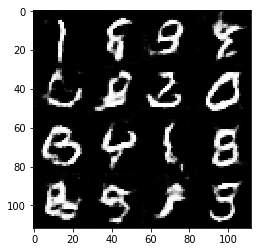

Epoch 1/3... Discriminator Loss: 0.7229... Generator Loss: 1.4488
Epoch 1/3... Discriminator Loss: 0.7172... Generator Loss: 1.6502
Epoch 1/3... Discriminator Loss: 0.6680... Generator Loss: 1.8042
Epoch 1/3... Discriminator Loss: 0.7590... Generator Loss: 1.2971
Epoch 2/3... Discriminator Loss: 0.7738... Generator Loss: 1.1859
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


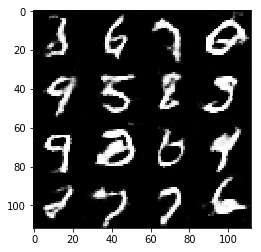

Epoch 2/3... Discriminator Loss: 0.8214... Generator Loss: 1.1124
Epoch 2/3... Discriminator Loss: 0.7744... Generator Loss: 1.1956
Epoch 2/3... Discriminator Loss: 0.9586... Generator Loss: 2.8635
Epoch 2/3... Discriminator Loss: 0.7672... Generator Loss: 1.2445
Epoch 2/3... Discriminator Loss: 0.7106... Generator Loss: 2.0324
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


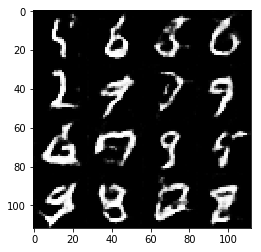

Epoch 2/3... Discriminator Loss: 0.7731... Generator Loss: 2.6203
Epoch 2/3... Discriminator Loss: 2.3651... Generator Loss: 4.5274
Epoch 2/3... Discriminator Loss: 0.7626... Generator Loss: 1.3980
Epoch 2/3... Discriminator Loss: 0.7090... Generator Loss: 2.2984
Epoch 2/3... Discriminator Loss: 0.5895... Generator Loss: 1.8509
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


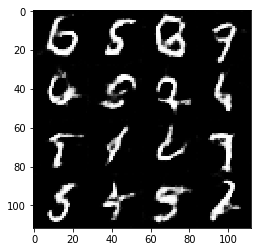

Epoch 2/3... Discriminator Loss: 0.7588... Generator Loss: 2.3680
Epoch 2/3... Discriminator Loss: 0.7204... Generator Loss: 1.2947
Epoch 2/3... Discriminator Loss: 0.6794... Generator Loss: 1.6468
Epoch 2/3... Discriminator Loss: 0.7262... Generator Loss: 2.3102
Epoch 2/3... Discriminator Loss: 0.6181... Generator Loss: 1.8784
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


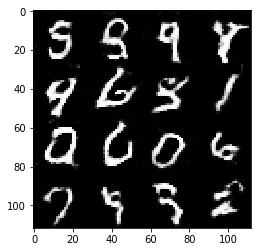

Epoch 2/3... Discriminator Loss: 0.8397... Generator Loss: 1.1337
Epoch 2/3... Discriminator Loss: 1.0126... Generator Loss: 3.0785
Epoch 2/3... Discriminator Loss: 1.5013... Generator Loss: 2.0515
Epoch 2/3... Discriminator Loss: 0.8875... Generator Loss: 1.2801
Epoch 2/3... Discriminator Loss: 0.7760... Generator Loss: 1.3129
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


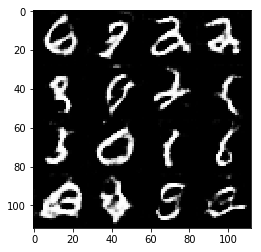

Epoch 2/3... Discriminator Loss: 0.6749... Generator Loss: 1.5587
Epoch 2/3... Discriminator Loss: 0.6507... Generator Loss: 2.1238
Epoch 2/3... Discriminator Loss: 0.8132... Generator Loss: 2.7085
Epoch 2/3... Discriminator Loss: 0.6771... Generator Loss: 1.5776
Epoch 2/3... Discriminator Loss: 0.7229... Generator Loss: 1.3659
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


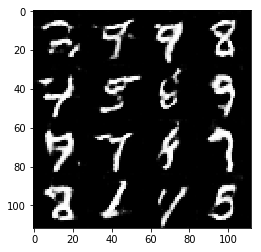

Epoch 2/3... Discriminator Loss: 0.6441... Generator Loss: 1.5213
Epoch 2/3... Discriminator Loss: 0.7660... Generator Loss: 1.3600
Epoch 2/3... Discriminator Loss: 0.6587... Generator Loss: 1.4934
Epoch 2/3... Discriminator Loss: 0.7140... Generator Loss: 1.3550
Epoch 2/3... Discriminator Loss: 0.5778... Generator Loss: 1.9688
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


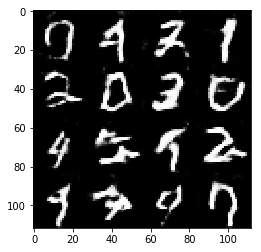

Epoch 2/3... Discriminator Loss: 0.6335... Generator Loss: 2.1066
Epoch 2/3... Discriminator Loss: 0.7404... Generator Loss: 2.6173
Epoch 2/3... Discriminator Loss: 1.4377... Generator Loss: 0.5267
Epoch 2/3... Discriminator Loss: 1.0867... Generator Loss: 0.8682
Epoch 2/3... Discriminator Loss: 0.8120... Generator Loss: 1.2006
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


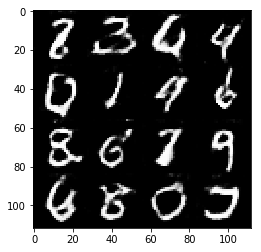

Epoch 2/3... Discriminator Loss: 0.6828... Generator Loss: 1.6262
Epoch 2/3... Discriminator Loss: 0.7494... Generator Loss: 2.5146
Epoch 2/3... Discriminator Loss: 0.6192... Generator Loss: 1.5906
Epoch 2/3... Discriminator Loss: 0.6856... Generator Loss: 2.4979
Epoch 2/3... Discriminator Loss: 0.5824... Generator Loss: 1.8305
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


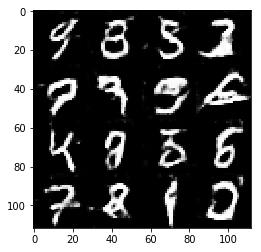

Epoch 2/3... Discriminator Loss: 0.7013... Generator Loss: 2.6268
Epoch 2/3... Discriminator Loss: 0.5755... Generator Loss: 2.3907
Epoch 2/3... Discriminator Loss: 0.6113... Generator Loss: 2.3525
Epoch 2/3... Discriminator Loss: 0.6009... Generator Loss: 1.9439
Epoch 2/3... Discriminator Loss: 0.6935... Generator Loss: 2.1699
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


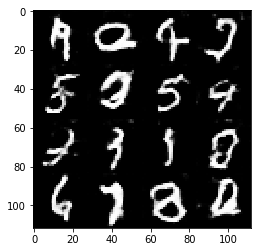

Epoch 2/3... Discriminator Loss: 0.5735... Generator Loss: 2.1480
CPU times: user 3min 1s, sys: 1min 6s, total: 4min 8s
Wall time: 6min 43s


In [26]:
%%time
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3
# tf.reset_default_graph()
        
mnist_dataset = helper.Dataset('mnist', glob(os.path.join('./data', 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

finished loading images.
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)
Epoch 0/1... Discriminator Loss: 0.6609... Generator Loss: 1.8851
Epoch 0/1... Discriminator Loss: 0.4736... Generator Loss: 2.7119
Epoch 0/1... Discriminator Loss: 0.4493... Generator Loss: 3.0171
Epoch 0/1... Discriminator Loss: 0.5232... Generator Loss: 2.6114
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


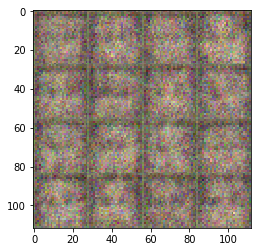

Epoch 0/1... Discriminator Loss: 0.4338... Generator Loss: 2.7011
Epoch 0/1... Discriminator Loss: 0.4308... Generator Loss: 3.5672
Epoch 0/1... Discriminator Loss: 0.4923... Generator Loss: 2.8094
Epoch 0/1... Discriminator Loss: 0.5066... Generator Loss: 3.2192
Epoch 0/1... Discriminator Loss: 0.4811... Generator Loss: 2.8571
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


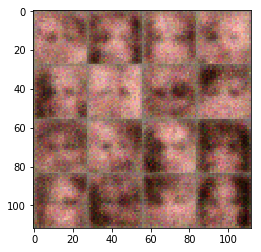

Epoch 0/1... Discriminator Loss: 0.4437... Generator Loss: 2.8774
Epoch 0/1... Discriminator Loss: 0.4108... Generator Loss: 3.1571
Epoch 0/1... Discriminator Loss: 0.4597... Generator Loss: 2.5302
Epoch 0/1... Discriminator Loss: 0.4024... Generator Loss: 3.5107
Epoch 0/1... Discriminator Loss: 0.4661... Generator Loss: 2.4741
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


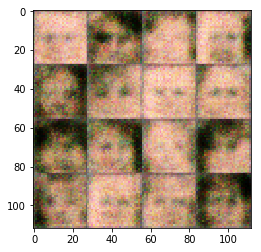

Epoch 0/1... Discriminator Loss: 0.4083... Generator Loss: 3.1912
Epoch 0/1... Discriminator Loss: 0.5534... Generator Loss: 2.1180
Epoch 0/1... Discriminator Loss: 0.4185... Generator Loss: 2.9745
Epoch 0/1... Discriminator Loss: 0.4219... Generator Loss: 2.8723
Epoch 0/1... Discriminator Loss: 0.3933... Generator Loss: 3.3397
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


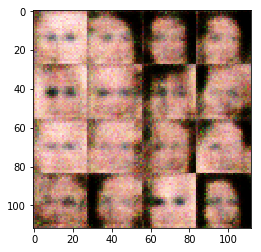

Epoch 0/1... Discriminator Loss: 0.4060... Generator Loss: 2.9316
Epoch 0/1... Discriminator Loss: 0.4005... Generator Loss: 3.2169
Epoch 0/1... Discriminator Loss: 0.7239... Generator Loss: 1.4644
Epoch 0/1... Discriminator Loss: 0.4338... Generator Loss: 4.8852
Epoch 0/1... Discriminator Loss: 0.4479... Generator Loss: 2.4815
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


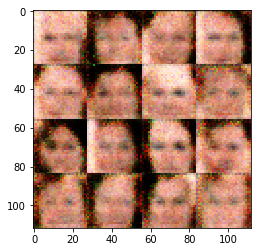

Epoch 0/1... Discriminator Loss: 0.3976... Generator Loss: 3.7695
Epoch 0/1... Discriminator Loss: 0.4746... Generator Loss: 2.4956
Epoch 0/1... Discriminator Loss: 0.4196... Generator Loss: 3.4148
Epoch 0/1... Discriminator Loss: 0.4549... Generator Loss: 2.8311
Epoch 0/1... Discriminator Loss: 0.4273... Generator Loss: 2.9342
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


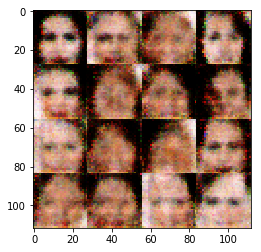

Epoch 0/1... Discriminator Loss: 0.4499... Generator Loss: 3.0089
Epoch 0/1... Discriminator Loss: 0.6096... Generator Loss: 1.7207
Epoch 0/1... Discriminator Loss: 0.6882... Generator Loss: 1.6752
Epoch 0/1... Discriminator Loss: 0.5178... Generator Loss: 2.2349
Epoch 0/1... Discriminator Loss: 0.4873... Generator Loss: 2.5717
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


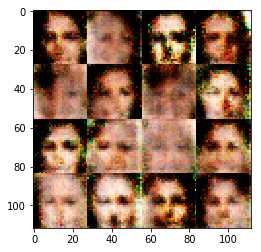

Epoch 0/1... Discriminator Loss: 0.5247... Generator Loss: 2.6505
Epoch 0/1... Discriminator Loss: 0.7151... Generator Loss: 1.7338
Epoch 0/1... Discriminator Loss: 0.5006... Generator Loss: 3.5127
Epoch 0/1... Discriminator Loss: 1.3419... Generator Loss: 1.1764
Epoch 0/1... Discriminator Loss: 0.7507... Generator Loss: 1.4004
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


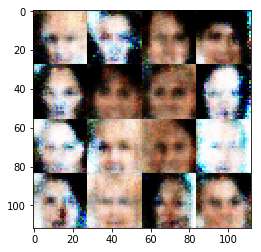

Epoch 0/1... Discriminator Loss: 0.8583... Generator Loss: 1.1120
Epoch 0/1... Discriminator Loss: 0.4835... Generator Loss: 3.1188
Epoch 0/1... Discriminator Loss: 0.5455... Generator Loss: 2.0398
Epoch 0/1... Discriminator Loss: 0.5289... Generator Loss: 2.2837
Epoch 0/1... Discriminator Loss: 0.4768... Generator Loss: 2.3650
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


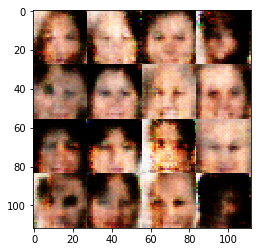

Epoch 0/1... Discriminator Loss: 0.5453... Generator Loss: 2.1844
Epoch 0/1... Discriminator Loss: 0.9936... Generator Loss: 1.1282
Epoch 0/1... Discriminator Loss: 0.7541... Generator Loss: 1.4196
Epoch 0/1... Discriminator Loss: 0.7030... Generator Loss: 1.4588
Epoch 0/1... Discriminator Loss: 0.8105... Generator Loss: 3.9934
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


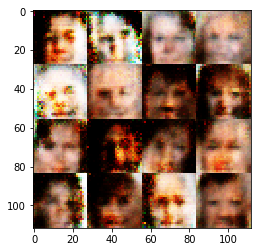

Epoch 0/1... Discriminator Loss: 0.6674... Generator Loss: 1.6390
Epoch 0/1... Discriminator Loss: 0.6570... Generator Loss: 1.7358
Epoch 0/1... Discriminator Loss: 0.6199... Generator Loss: 1.9334
Epoch 0/1... Discriminator Loss: 0.6422... Generator Loss: 2.0611
Epoch 0/1... Discriminator Loss: 0.5502... Generator Loss: 2.1443
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


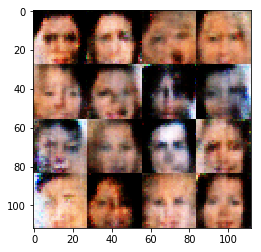

Epoch 0/1... Discriminator Loss: 0.8674... Generator Loss: 1.2616
Epoch 0/1... Discriminator Loss: 1.0521... Generator Loss: 1.0523
Epoch 0/1... Discriminator Loss: 0.7071... Generator Loss: 1.5425
Epoch 0/1... Discriminator Loss: 0.7337... Generator Loss: 2.8311
Epoch 0/1... Discriminator Loss: 0.8062... Generator Loss: 2.4161
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


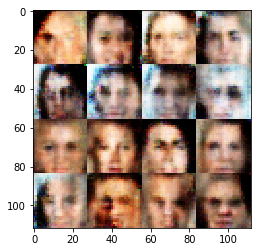

Epoch 0/1... Discriminator Loss: 0.4743... Generator Loss: 3.0002
Epoch 0/1... Discriminator Loss: 0.8826... Generator Loss: 1.0546
Epoch 0/1... Discriminator Loss: 0.9901... Generator Loss: 0.9446
Epoch 0/1... Discriminator Loss: 0.9698... Generator Loss: 1.1011
Epoch 0/1... Discriminator Loss: 0.9152... Generator Loss: 1.1066
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


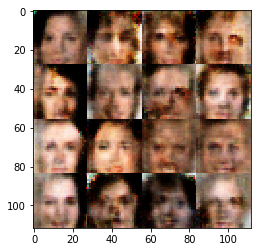

Epoch 0/1... Discriminator Loss: 0.7733... Generator Loss: 1.5080
Epoch 0/1... Discriminator Loss: 0.7987... Generator Loss: 1.8866
Epoch 0/1... Discriminator Loss: 0.9960... Generator Loss: 2.5963
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 0.8062
Epoch 0/1... Discriminator Loss: 0.8062... Generator Loss: 1.3867
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


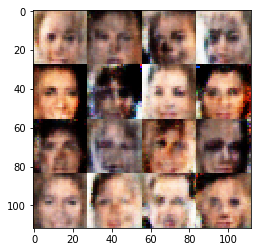

Epoch 0/1... Discriminator Loss: 2.1096... Generator Loss: 4.1092
Epoch 0/1... Discriminator Loss: 0.9673... Generator Loss: 2.1700
Epoch 0/1... Discriminator Loss: 0.9283... Generator Loss: 1.1850
Epoch 0/1... Discriminator Loss: 0.7850... Generator Loss: 1.7530
Epoch 0/1... Discriminator Loss: 0.9536... Generator Loss: 2.3871
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


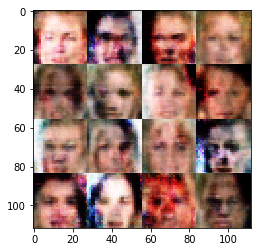

Epoch 0/1... Discriminator Loss: 0.8587... Generator Loss: 1.4351
Epoch 0/1... Discriminator Loss: 0.8499... Generator Loss: 1.3349
Epoch 0/1... Discriminator Loss: 0.7619... Generator Loss: 1.9249
Epoch 0/1... Discriminator Loss: 1.1948... Generator Loss: 2.3645
Epoch 0/1... Discriminator Loss: 0.8539... Generator Loss: 1.2463
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


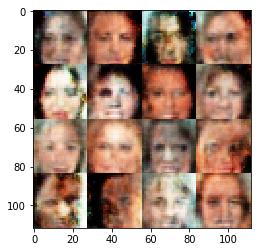

Epoch 0/1... Discriminator Loss: 0.8950... Generator Loss: 1.1079
Epoch 0/1... Discriminator Loss: 0.8506... Generator Loss: 1.1367
Epoch 0/1... Discriminator Loss: 0.9493... Generator Loss: 1.2694
Epoch 0/1... Discriminator Loss: 1.0233... Generator Loss: 1.1814
Epoch 0/1... Discriminator Loss: 1.0074... Generator Loss: 2.1079
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


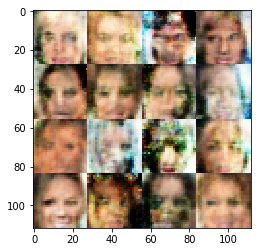

Epoch 0/1... Discriminator Loss: 0.8835... Generator Loss: 1.7943
Epoch 0/1... Discriminator Loss: 1.0071... Generator Loss: 0.7837
Epoch 0/1... Discriminator Loss: 0.7883... Generator Loss: 1.5002
Epoch 0/1... Discriminator Loss: 0.9985... Generator Loss: 1.9253
Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 1.1393
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


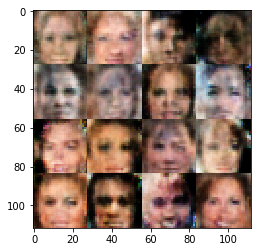

Epoch 0/1... Discriminator Loss: 0.9049... Generator Loss: 1.1188
Epoch 0/1... Discriminator Loss: 1.1227... Generator Loss: 0.6396
Epoch 0/1... Discriminator Loss: 1.2211... Generator Loss: 0.7008
Epoch 0/1... Discriminator Loss: 1.2219... Generator Loss: 0.8309
Epoch 0/1... Discriminator Loss: 0.9409... Generator Loss: 1.1799
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


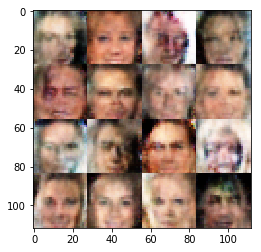

Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 1.4014
Epoch 0/1... Discriminator Loss: 1.0086... Generator Loss: 1.6931
Epoch 0/1... Discriminator Loss: 0.9281... Generator Loss: 1.5811
Epoch 0/1... Discriminator Loss: 0.9375... Generator Loss: 1.9909
Epoch 0/1... Discriminator Loss: 1.0839... Generator Loss: 0.9995
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


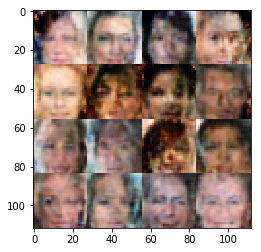

Epoch 0/1... Discriminator Loss: 1.0651... Generator Loss: 1.5819
Epoch 0/1... Discriminator Loss: 1.0736... Generator Loss: 1.2954
Epoch 0/1... Discriminator Loss: 0.9616... Generator Loss: 1.1690
Epoch 0/1... Discriminator Loss: 0.8243... Generator Loss: 1.3688
Epoch 0/1... Discriminator Loss: 1.1236... Generator Loss: 0.8140
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


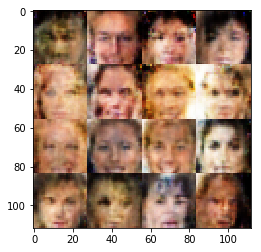

Epoch 0/1... Discriminator Loss: 1.0524... Generator Loss: 1.1246
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 0.9903
Epoch 0/1... Discriminator Loss: 0.9676... Generator Loss: 1.2734
Epoch 0/1... Discriminator Loss: 0.9881... Generator Loss: 1.0210
Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 0.8553
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


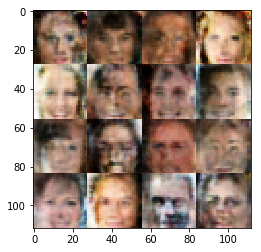

Epoch 0/1... Discriminator Loss: 0.9425... Generator Loss: 1.1615
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.0940
Epoch 0/1... Discriminator Loss: 0.9251... Generator Loss: 1.4366
Epoch 0/1... Discriminator Loss: 0.9965... Generator Loss: 1.1190
Epoch 0/1... Discriminator Loss: 1.0204... Generator Loss: 1.0173
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


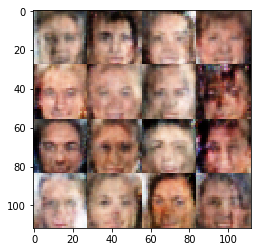

Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 1.0463
Epoch 0/1... Discriminator Loss: 1.0216... Generator Loss: 1.0063
Epoch 0/1... Discriminator Loss: 1.0261... Generator Loss: 1.1572
Epoch 0/1... Discriminator Loss: 0.9728... Generator Loss: 1.4595
Epoch 0/1... Discriminator Loss: 0.9901... Generator Loss: 1.2886
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


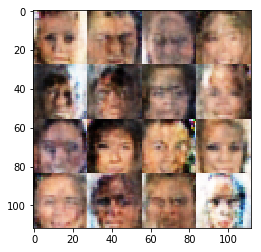

Epoch 0/1... Discriminator Loss: 1.1063... Generator Loss: 0.9543
Epoch 0/1... Discriminator Loss: 1.1024... Generator Loss: 1.3704
Epoch 0/1... Discriminator Loss: 1.0732... Generator Loss: 1.0682
Epoch 0/1... Discriminator Loss: 1.1635... Generator Loss: 1.5405
Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 1.3017
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


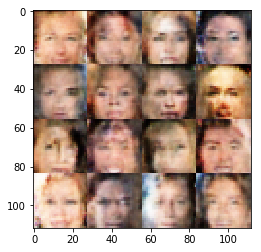

Epoch 0/1... Discriminator Loss: 1.3184... Generator Loss: 0.5298
Epoch 0/1... Discriminator Loss: 1.2446... Generator Loss: 0.7976
Epoch 0/1... Discriminator Loss: 0.9875... Generator Loss: 1.1722
Epoch 0/1... Discriminator Loss: 1.4687... Generator Loss: 0.5395
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.8138
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


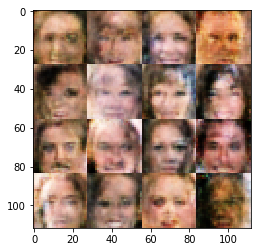

Epoch 0/1... Discriminator Loss: 1.2060... Generator Loss: 0.6760
Epoch 0/1... Discriminator Loss: 0.7943... Generator Loss: 1.2399
Epoch 0/1... Discriminator Loss: 0.9799... Generator Loss: 1.2038
Epoch 0/1... Discriminator Loss: 0.9982... Generator Loss: 0.9857
Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 1.1823
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


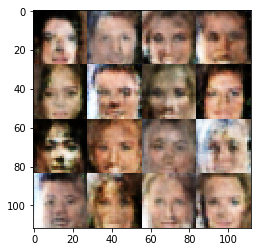

Epoch 0/1... Discriminator Loss: 1.0269... Generator Loss: 0.8428
Epoch 0/1... Discriminator Loss: 0.8810... Generator Loss: 1.1769
Epoch 0/1... Discriminator Loss: 1.0823... Generator Loss: 0.9743
Epoch 0/1... Discriminator Loss: 1.0219... Generator Loss: 1.0805
Epoch 0/1... Discriminator Loss: 0.9396... Generator Loss: 2.1819
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


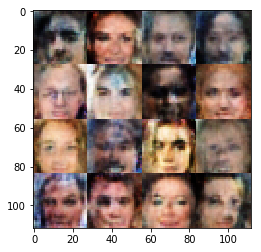

Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.7225
Epoch 0/1... Discriminator Loss: 1.2023... Generator Loss: 0.6282
Epoch 0/1... Discriminator Loss: 1.0017... Generator Loss: 0.9756
Epoch 0/1... Discriminator Loss: 1.1520... Generator Loss: 0.9323
Epoch 0/1... Discriminator Loss: 0.8657... Generator Loss: 1.1201
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


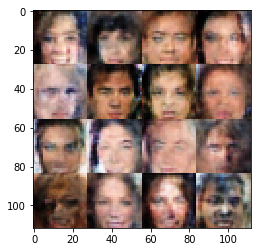

Epoch 0/1... Discriminator Loss: 0.9576... Generator Loss: 1.2186
Epoch 0/1... Discriminator Loss: 1.4022... Generator Loss: 2.1432
Epoch 0/1... Discriminator Loss: 1.2562... Generator Loss: 0.6650
Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 0.9642
Epoch 0/1... Discriminator Loss: 0.9624... Generator Loss: 1.2590
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


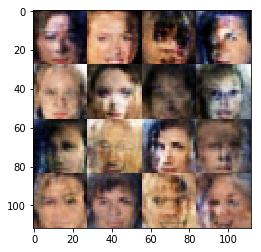

Epoch 0/1... Discriminator Loss: 1.0418... Generator Loss: 0.9999
Epoch 0/1... Discriminator Loss: 0.7997... Generator Loss: 1.6098
Epoch 0/1... Discriminator Loss: 0.9152... Generator Loss: 1.0818
Epoch 0/1... Discriminator Loss: 1.0420... Generator Loss: 0.8609
Epoch 0/1... Discriminator Loss: 1.4178... Generator Loss: 0.6247
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


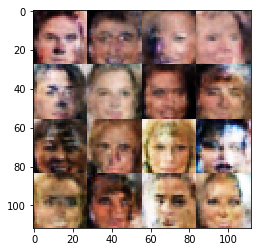

Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 1.2804
Epoch 0/1... Discriminator Loss: 0.9695... Generator Loss: 1.1855
Epoch 0/1... Discriminator Loss: 0.9677... Generator Loss: 1.0266
Epoch 0/1... Discriminator Loss: 1.0089... Generator Loss: 1.2546
Epoch 0/1... Discriminator Loss: 1.0397... Generator Loss: 1.0245
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


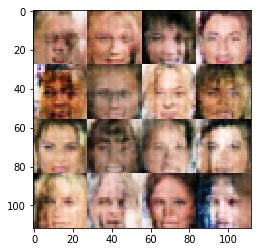

Epoch 0/1... Discriminator Loss: 1.0092... Generator Loss: 0.9567
Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 0.8193
Epoch 0/1... Discriminator Loss: 0.9652... Generator Loss: 0.9806
Epoch 0/1... Discriminator Loss: 0.9249... Generator Loss: 1.6591
Epoch 0/1... Discriminator Loss: 0.7951... Generator Loss: 1.7094
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


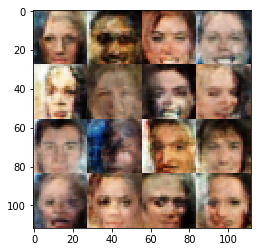

Epoch 0/1... Discriminator Loss: 0.9242... Generator Loss: 1.4771
Epoch 0/1... Discriminator Loss: 1.1513... Generator Loss: 1.0248
Epoch 0/1... Discriminator Loss: 1.1507... Generator Loss: 0.8400
Epoch 0/1... Discriminator Loss: 1.3564... Generator Loss: 0.6727
Epoch 0/1... Discriminator Loss: 0.8550... Generator Loss: 1.4245
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


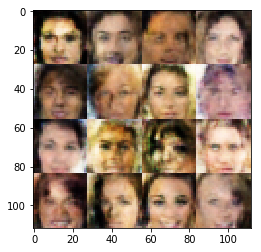

Epoch 0/1... Discriminator Loss: 1.1668... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.0101... Generator Loss: 1.0527
Epoch 0/1... Discriminator Loss: 1.1851... Generator Loss: 0.7635
Epoch 0/1... Discriminator Loss: 0.9024... Generator Loss: 1.2592
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 0.7080
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


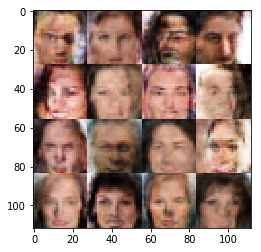

Epoch 0/1... Discriminator Loss: 1.0375... Generator Loss: 1.4803
Epoch 0/1... Discriminator Loss: 0.9606... Generator Loss: 1.1072
Epoch 0/1... Discriminator Loss: 1.0001... Generator Loss: 0.8661
Epoch 0/1... Discriminator Loss: 1.2143... Generator Loss: 0.6638
Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 1.1956
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


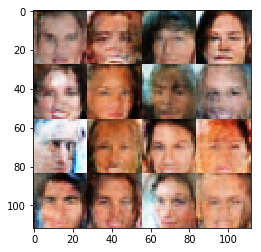

Epoch 0/1... Discriminator Loss: 1.1387... Generator Loss: 1.0641
Epoch 0/1... Discriminator Loss: 0.9459... Generator Loss: 1.1350
Epoch 0/1... Discriminator Loss: 1.0621... Generator Loss: 0.8833
Epoch 0/1... Discriminator Loss: 1.3236... Generator Loss: 0.6137
Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 0.5792
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


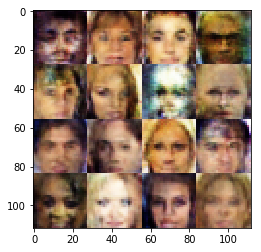

Epoch 0/1... Discriminator Loss: 1.1012... Generator Loss: 0.9765
Epoch 0/1... Discriminator Loss: 1.0801... Generator Loss: 0.9762
Epoch 0/1... Discriminator Loss: 1.0273... Generator Loss: 0.8968
Epoch 0/1... Discriminator Loss: 1.1011... Generator Loss: 0.9441
Epoch 0/1... Discriminator Loss: 0.8906... Generator Loss: 1.0759
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


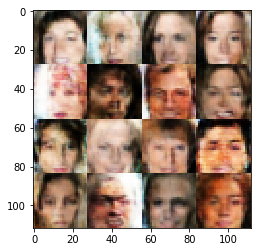

Epoch 0/1... Discriminator Loss: 0.9363... Generator Loss: 1.3598
Epoch 0/1... Discriminator Loss: 1.1145... Generator Loss: 0.9601
Epoch 0/1... Discriminator Loss: 1.4155... Generator Loss: 0.8805
Epoch 0/1... Discriminator Loss: 1.1382... Generator Loss: 1.1931
Epoch 0/1... Discriminator Loss: 1.0534... Generator Loss: 1.2986
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


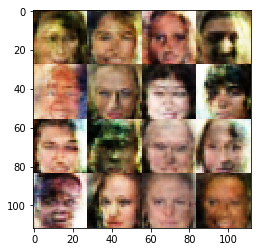

Epoch 0/1... Discriminator Loss: 0.9930... Generator Loss: 0.9980
Epoch 0/1... Discriminator Loss: 1.0174... Generator Loss: 0.9098
Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.8021
Epoch 0/1... Discriminator Loss: 0.9730... Generator Loss: 1.0312
Epoch 0/1... Discriminator Loss: 0.8620... Generator Loss: 1.1862
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


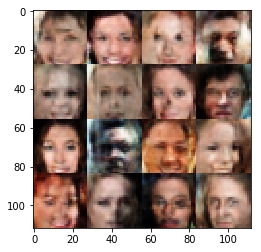

Epoch 0/1... Discriminator Loss: 1.1780... Generator Loss: 0.7233
Epoch 0/1... Discriminator Loss: 1.0236... Generator Loss: 1.0402
Epoch 0/1... Discriminator Loss: 0.9141... Generator Loss: 1.0603
Epoch 0/1... Discriminator Loss: 0.9883... Generator Loss: 1.4449
Epoch 0/1... Discriminator Loss: 0.9126... Generator Loss: 1.2875
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


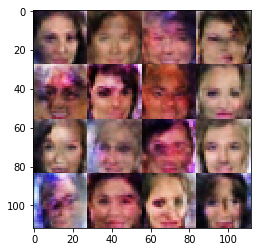

Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 1.0024
Epoch 0/1... Discriminator Loss: 1.0389... Generator Loss: 0.9024
Epoch 0/1... Discriminator Loss: 0.9084... Generator Loss: 1.2290
Epoch 0/1... Discriminator Loss: 1.1119... Generator Loss: 0.9785
Epoch 0/1... Discriminator Loss: 1.1900... Generator Loss: 0.8865
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


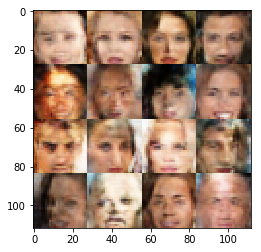

Epoch 0/1... Discriminator Loss: 1.2216... Generator Loss: 0.8676
Epoch 0/1... Discriminator Loss: 0.8360... Generator Loss: 1.4169
Epoch 0/1... Discriminator Loss: 1.0875... Generator Loss: 0.8839
Epoch 0/1... Discriminator Loss: 1.5509... Generator Loss: 0.4851
Epoch 0/1... Discriminator Loss: 0.8746... Generator Loss: 1.4001
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


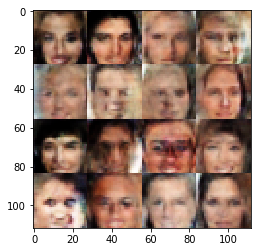

Epoch 0/1... Discriminator Loss: 1.1712... Generator Loss: 0.8730
Epoch 0/1... Discriminator Loss: 0.9342... Generator Loss: 0.8939
Epoch 0/1... Discriminator Loss: 0.8847... Generator Loss: 1.0662
Epoch 0/1... Discriminator Loss: 0.9215... Generator Loss: 1.3317
Epoch 0/1... Discriminator Loss: 1.0254... Generator Loss: 0.9296
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


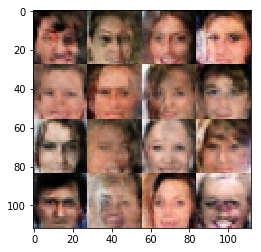

Epoch 0/1... Discriminator Loss: 0.9088... Generator Loss: 1.4525
Epoch 0/1... Discriminator Loss: 1.1086... Generator Loss: 0.7575
Epoch 0/1... Discriminator Loss: 0.8832... Generator Loss: 1.1530
Epoch 0/1... Discriminator Loss: 1.3382... Generator Loss: 0.4880
Epoch 0/1... Discriminator Loss: 1.0925... Generator Loss: 1.1957
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


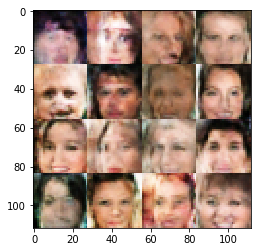

Epoch 0/1... Discriminator Loss: 0.9664... Generator Loss: 1.0210
Epoch 0/1... Discriminator Loss: 0.9187... Generator Loss: 1.2953
Epoch 0/1... Discriminator Loss: 1.0664... Generator Loss: 1.2017
Epoch 0/1... Discriminator Loss: 1.1998... Generator Loss: 1.0431
Epoch 0/1... Discriminator Loss: 1.0481... Generator Loss: 0.8875
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


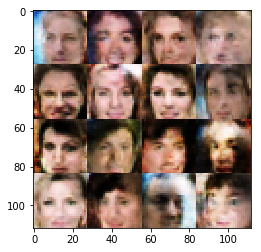

Epoch 0/1... Discriminator Loss: 1.1316... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 1.2022
Epoch 0/1... Discriminator Loss: 0.8472... Generator Loss: 1.1276
Epoch 0/1... Discriminator Loss: 1.1160... Generator Loss: 0.9123
Epoch 0/1... Discriminator Loss: 1.0860... Generator Loss: 1.0700
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


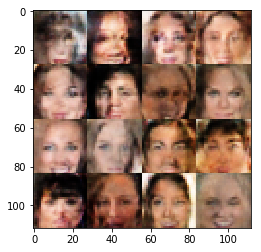

Epoch 0/1... Discriminator Loss: 1.0303... Generator Loss: 1.4933
Epoch 0/1... Discriminator Loss: 1.1321... Generator Loss: 0.8014
Epoch 0/1... Discriminator Loss: 1.2629... Generator Loss: 0.9384
Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.9524
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 0.9246
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


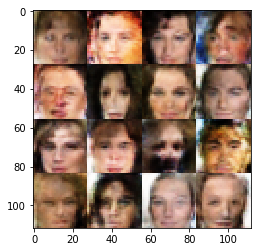

Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 1.1314
Epoch 0/1... Discriminator Loss: 0.9394... Generator Loss: 1.2529
Epoch 0/1... Discriminator Loss: 1.0764... Generator Loss: 0.8303
Epoch 0/1... Discriminator Loss: 1.1329... Generator Loss: 0.8939
Epoch 0/1... Discriminator Loss: 0.8656... Generator Loss: 1.5485
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


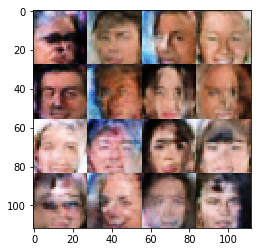

Epoch 0/1... Discriminator Loss: 1.3292... Generator Loss: 0.6894
Epoch 0/1... Discriminator Loss: 0.9537... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 0.8095... Generator Loss: 1.4777
Epoch 0/1... Discriminator Loss: 1.1063... Generator Loss: 0.9608
Epoch 0/1... Discriminator Loss: 1.2757... Generator Loss: 0.6247
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


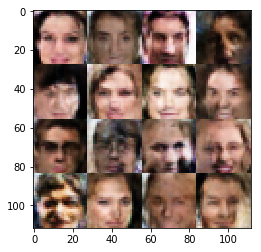

Epoch 0/1... Discriminator Loss: 1.0120... Generator Loss: 0.9594
Epoch 0/1... Discriminator Loss: 0.8018... Generator Loss: 1.3020
Epoch 0/1... Discriminator Loss: 1.1657... Generator Loss: 1.1047
Epoch 0/1... Discriminator Loss: 1.0999... Generator Loss: 0.8455
Epoch 0/1... Discriminator Loss: 1.0149... Generator Loss: 0.9891
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


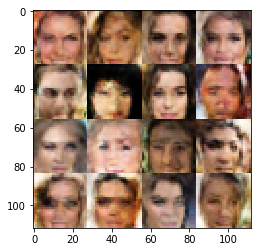

Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 1.2330
Epoch 0/1... Discriminator Loss: 1.0372... Generator Loss: 0.9459
Epoch 0/1... Discriminator Loss: 0.9785... Generator Loss: 1.4416
Epoch 0/1... Discriminator Loss: 0.9940... Generator Loss: 0.9424
Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.6855
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


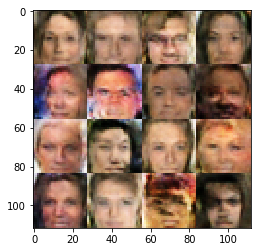

Epoch 0/1... Discriminator Loss: 0.8642... Generator Loss: 1.2885
Epoch 0/1... Discriminator Loss: 1.0748... Generator Loss: 0.8683
Epoch 0/1... Discriminator Loss: 1.1023... Generator Loss: 0.9586
Epoch 0/1... Discriminator Loss: 0.9666... Generator Loss: 1.2096
Epoch 0/1... Discriminator Loss: 1.2860... Generator Loss: 0.7551
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


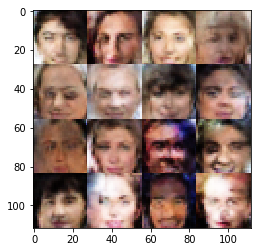

Epoch 0/1... Discriminator Loss: 1.1756... Generator Loss: 0.7040
Epoch 0/1... Discriminator Loss: 0.9361... Generator Loss: 1.2324
Epoch 0/1... Discriminator Loss: 0.8223... Generator Loss: 1.3575
Epoch 0/1... Discriminator Loss: 1.0807... Generator Loss: 1.2082
Epoch 0/1... Discriminator Loss: 0.9887... Generator Loss: 1.0914
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


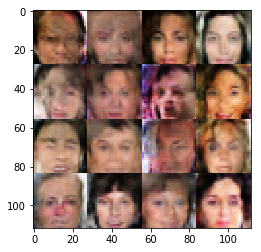

Epoch 0/1... Discriminator Loss: 1.1250... Generator Loss: 0.7661
Epoch 0/1... Discriminator Loss: 0.8507... Generator Loss: 1.7282
Epoch 0/1... Discriminator Loss: 0.8946... Generator Loss: 1.1148
Epoch 0/1... Discriminator Loss: 0.9764... Generator Loss: 0.9980
Epoch 0/1... Discriminator Loss: 0.9701... Generator Loss: 1.1037
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


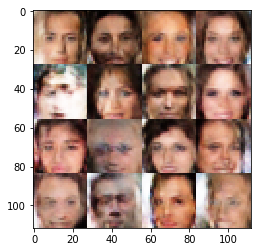

Epoch 0/1... Discriminator Loss: 1.2722... Generator Loss: 0.6206
Epoch 0/1... Discriminator Loss: 0.9422... Generator Loss: 1.2152
Epoch 0/1... Discriminator Loss: 1.1235... Generator Loss: 0.8942
Epoch 0/1... Discriminator Loss: 1.0144... Generator Loss: 0.9886
Epoch 0/1... Discriminator Loss: 1.0806... Generator Loss: 0.7905
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


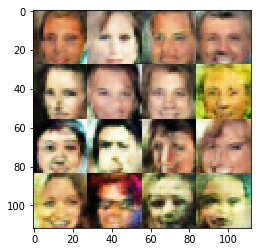

Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 0.6846
Epoch 0/1... Discriminator Loss: 1.0872... Generator Loss: 0.7189
Epoch 0/1... Discriminator Loss: 1.1518... Generator Loss: 0.7163
Epoch 0/1... Discriminator Loss: 1.0555... Generator Loss: 0.8077
Epoch 0/1... Discriminator Loss: 0.8520... Generator Loss: 1.2578
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


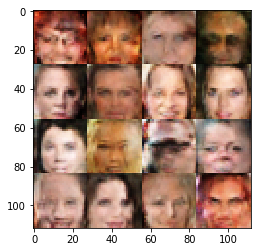

Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.1529
Epoch 0/1... Discriminator Loss: 1.0381... Generator Loss: 1.1764
Epoch 0/1... Discriminator Loss: 1.0924... Generator Loss: 1.0289
Epoch 0/1... Discriminator Loss: 0.8486... Generator Loss: 1.5063
Epoch 0/1... Discriminator Loss: 1.1212... Generator Loss: 1.4641
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


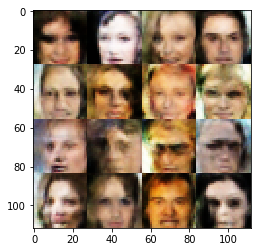

Epoch 0/1... Discriminator Loss: 0.9055... Generator Loss: 0.8627
Epoch 0/1... Discriminator Loss: 0.9807... Generator Loss: 1.1330
Epoch 0/1... Discriminator Loss: 1.0885... Generator Loss: 0.9611
Epoch 0/1... Discriminator Loss: 1.0518... Generator Loss: 1.0018
Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.5531
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


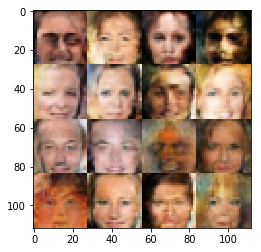

Epoch 0/1... Discriminator Loss: 1.0698... Generator Loss: 0.6852
Epoch 0/1... Discriminator Loss: 0.9740... Generator Loss: 1.1145
Epoch 0/1... Discriminator Loss: 1.3867... Generator Loss: 0.5849
Epoch 0/1... Discriminator Loss: 0.8798... Generator Loss: 1.2334
Epoch 0/1... Discriminator Loss: 0.9942... Generator Loss: 1.0044
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


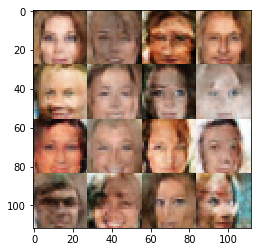

Epoch 0/1... Discriminator Loss: 1.1927... Generator Loss: 0.7525
Epoch 0/1... Discriminator Loss: 1.1384... Generator Loss: 0.8343
Epoch 0/1... Discriminator Loss: 1.1211... Generator Loss: 0.7043
Epoch 0/1... Discriminator Loss: 1.0925... Generator Loss: 0.9705
Epoch 0/1... Discriminator Loss: 1.1229... Generator Loss: 0.8354
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


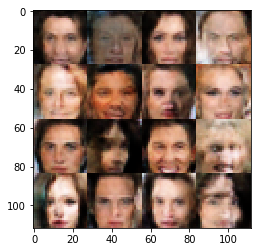

Epoch 0/1... Discriminator Loss: 1.0065... Generator Loss: 0.9951
Epoch 0/1... Discriminator Loss: 1.2572... Generator Loss: 0.6800
Epoch 0/1... Discriminator Loss: 0.8842... Generator Loss: 1.2769
Epoch 0/1... Discriminator Loss: 1.1575... Generator Loss: 0.7899
Epoch 0/1... Discriminator Loss: 0.8569... Generator Loss: 1.1246
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


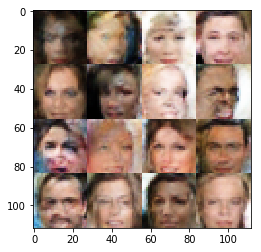

Epoch 0/1... Discriminator Loss: 0.7458... Generator Loss: 1.2841
Epoch 0/1... Discriminator Loss: 0.8915... Generator Loss: 1.5307
Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.7672
Epoch 0/1... Discriminator Loss: 1.1514... Generator Loss: 0.9253
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 0.7787
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


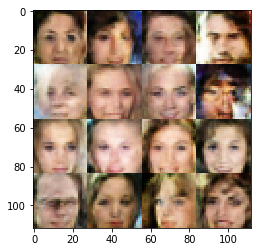

Epoch 0/1... Discriminator Loss: 1.1557... Generator Loss: 0.7792
Epoch 0/1... Discriminator Loss: 1.0268... Generator Loss: 0.8922
Epoch 0/1... Discriminator Loss: 0.9942... Generator Loss: 1.1921
Epoch 0/1... Discriminator Loss: 0.9467... Generator Loss: 0.9578
Epoch 0/1... Discriminator Loss: 1.0519... Generator Loss: 0.9881
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


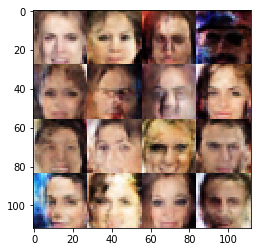

Epoch 0/1... Discriminator Loss: 0.9486... Generator Loss: 0.9509
Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 0.9593
Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.9704
Epoch 0/1... Discriminator Loss: 1.0737... Generator Loss: 0.7491
Epoch 0/1... Discriminator Loss: 0.7935... Generator Loss: 1.5510
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


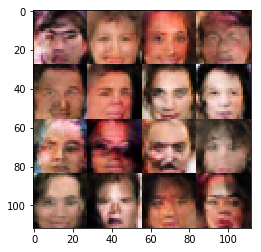

Epoch 0/1... Discriminator Loss: 1.0780... Generator Loss: 0.8504
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.1004
Epoch 0/1... Discriminator Loss: 1.2082... Generator Loss: 0.6629
Epoch 0/1... Discriminator Loss: 0.8893... Generator Loss: 1.3504
Epoch 0/1... Discriminator Loss: 0.9496... Generator Loss: 1.2562
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


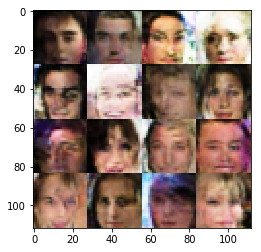

Epoch 0/1... Discriminator Loss: 1.3598... Generator Loss: 0.6073
Epoch 0/1... Discriminator Loss: 1.0453... Generator Loss: 1.3631
Epoch 0/1... Discriminator Loss: 0.6761... Generator Loss: 1.3912
Epoch 0/1... Discriminator Loss: 0.8589... Generator Loss: 2.1633
Epoch 0/1... Discriminator Loss: 1.3141... Generator Loss: 0.5827
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


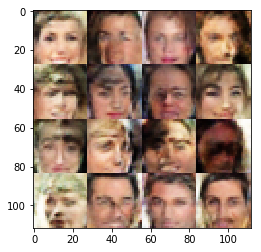

Epoch 0/1... Discriminator Loss: 1.0926... Generator Loss: 0.7977
Epoch 0/1... Discriminator Loss: 0.9443... Generator Loss: 0.9403
Epoch 0/1... Discriminator Loss: 0.8057... Generator Loss: 1.4286
Epoch 0/1... Discriminator Loss: 1.0318... Generator Loss: 0.9103
Epoch 0/1... Discriminator Loss: 1.0294... Generator Loss: 0.7353
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


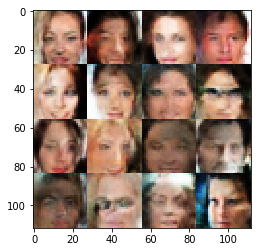

Epoch 0/1... Discriminator Loss: 1.0161... Generator Loss: 1.2566
Epoch 0/1... Discriminator Loss: 0.7309... Generator Loss: 1.8131
Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.7374
Epoch 0/1... Discriminator Loss: 0.8826... Generator Loss: 1.1518
Epoch 0/1... Discriminator Loss: 1.1959... Generator Loss: 0.5993
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


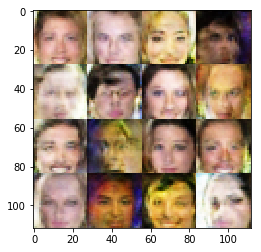

Epoch 0/1... Discriminator Loss: 1.3210... Generator Loss: 0.5554
Epoch 0/1... Discriminator Loss: 1.2793... Generator Loss: 0.6255
Epoch 0/1... Discriminator Loss: 1.1054... Generator Loss: 0.9093
Epoch 0/1... Discriminator Loss: 1.1238... Generator Loss: 0.8684
Epoch 0/1... Discriminator Loss: 0.8923... Generator Loss: 0.9641
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


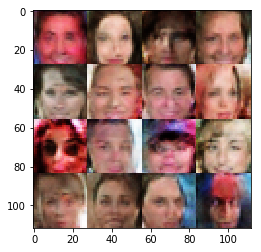

Epoch 0/1... Discriminator Loss: 1.1890... Generator Loss: 0.6683
Epoch 0/1... Discriminator Loss: 0.9156... Generator Loss: 1.2334
Epoch 0/1... Discriminator Loss: 0.8456... Generator Loss: 1.0875
Epoch 0/1... Discriminator Loss: 0.9007... Generator Loss: 0.9664
Epoch 0/1... Discriminator Loss: 1.1917... Generator Loss: 0.5761
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


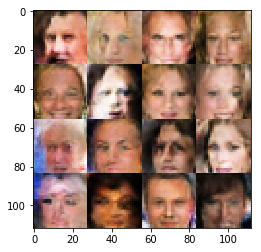

Epoch 0/1... Discriminator Loss: 1.0419... Generator Loss: 1.3524
Epoch 0/1... Discriminator Loss: 1.1895... Generator Loss: 0.6554
Epoch 0/1... Discriminator Loss: 0.9867... Generator Loss: 0.9582
Epoch 0/1... Discriminator Loss: 1.1804... Generator Loss: 0.6898
Epoch 0/1... Discriminator Loss: 1.0221... Generator Loss: 0.8594
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


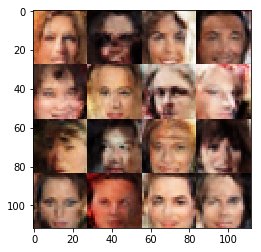

Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 0.6407
Epoch 0/1... Discriminator Loss: 1.0913... Generator Loss: 0.7953
Epoch 0/1... Discriminator Loss: 0.9626... Generator Loss: 1.2460
Epoch 0/1... Discriminator Loss: 0.8665... Generator Loss: 1.1383
Epoch 0/1... Discriminator Loss: 1.0969... Generator Loss: 1.1873
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


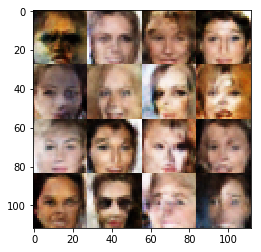

Epoch 0/1... Discriminator Loss: 0.7209... Generator Loss: 1.5694
Epoch 0/1... Discriminator Loss: 1.0174... Generator Loss: 0.8963
Epoch 0/1... Discriminator Loss: 0.8964... Generator Loss: 1.0891
Epoch 0/1... Discriminator Loss: 0.8304... Generator Loss: 1.0607
Epoch 0/1... Discriminator Loss: 0.9840... Generator Loss: 1.0169
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


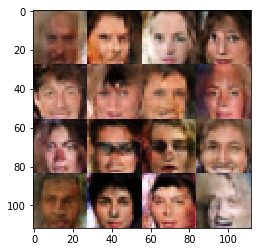

Epoch 0/1... Discriminator Loss: 0.8716... Generator Loss: 1.1111
Epoch 0/1... Discriminator Loss: 0.9825... Generator Loss: 0.9614
Epoch 0/1... Discriminator Loss: 1.0543... Generator Loss: 0.7955
Epoch 0/1... Discriminator Loss: 0.9309... Generator Loss: 1.2240
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 0.6664
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


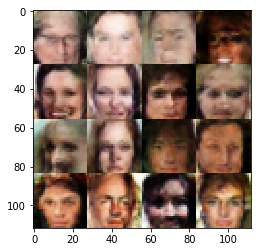

Epoch 0/1... Discriminator Loss: 0.8684... Generator Loss: 1.3078
Epoch 0/1... Discriminator Loss: 1.0291... Generator Loss: 1.7887
Epoch 0/1... Discriminator Loss: 1.0850... Generator Loss: 0.9528
Epoch 0/1... Discriminator Loss: 1.0964... Generator Loss: 0.8340
Epoch 0/1... Discriminator Loss: 0.6892... Generator Loss: 2.0684
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


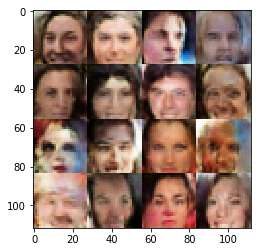

Epoch 0/1... Discriminator Loss: 1.0862... Generator Loss: 0.7781
Epoch 0/1... Discriminator Loss: 0.9601... Generator Loss: 1.1294
Epoch 0/1... Discriminator Loss: 0.8704... Generator Loss: 1.3009
Epoch 0/1... Discriminator Loss: 1.1159... Generator Loss: 1.0292
Epoch 0/1... Discriminator Loss: 0.8205... Generator Loss: 1.2140
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


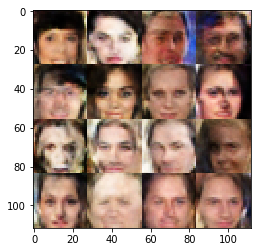

Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 1.0677
Epoch 0/1... Discriminator Loss: 1.2155... Generator Loss: 0.5977
Epoch 0/1... Discriminator Loss: 0.8812... Generator Loss: 1.2329
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 0.9815
Epoch 0/1... Discriminator Loss: 1.4510... Generator Loss: 0.4890
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


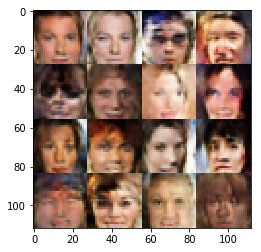

Epoch 0/1... Discriminator Loss: 0.8993... Generator Loss: 1.5096
Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.6827
Epoch 0/1... Discriminator Loss: 0.9043... Generator Loss: 1.0438
Epoch 0/1... Discriminator Loss: 0.9335... Generator Loss: 1.1462
Epoch 0/1... Discriminator Loss: 1.2826... Generator Loss: 0.6426
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


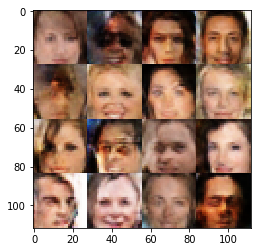

Epoch 0/1... Discriminator Loss: 0.8525... Generator Loss: 1.1785
Epoch 0/1... Discriminator Loss: 1.0982... Generator Loss: 0.7994
Epoch 0/1... Discriminator Loss: 1.0390... Generator Loss: 1.2336
Epoch 0/1... Discriminator Loss: 0.9201... Generator Loss: 1.0081
Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 0.9713
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


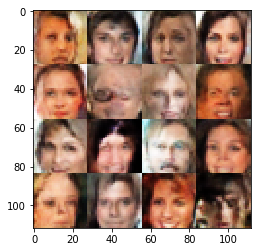

Epoch 0/1... Discriminator Loss: 0.8688... Generator Loss: 1.1814
Epoch 0/1... Discriminator Loss: 1.3425... Generator Loss: 0.5554
Epoch 0/1... Discriminator Loss: 0.7938... Generator Loss: 1.4566
Epoch 0/1... Discriminator Loss: 0.8885... Generator Loss: 1.3969
Epoch 0/1... Discriminator Loss: 1.3307... Generator Loss: 0.4771
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


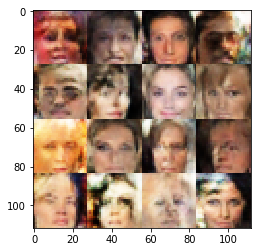

Epoch 0/1... Discriminator Loss: 0.8906... Generator Loss: 1.1498
Epoch 0/1... Discriminator Loss: 1.0427... Generator Loss: 1.0724
Epoch 0/1... Discriminator Loss: 0.9992... Generator Loss: 0.9820
Epoch 0/1... Discriminator Loss: 1.2928... Generator Loss: 0.7204
Epoch 0/1... Discriminator Loss: 1.0198... Generator Loss: 0.9181
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


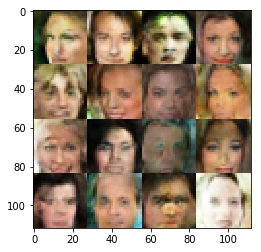

Epoch 0/1... Discriminator Loss: 0.8458... Generator Loss: 1.1157
Epoch 0/1... Discriminator Loss: 1.0282... Generator Loss: 1.2245
Epoch 0/1... Discriminator Loss: 1.3128... Generator Loss: 0.4918
Epoch 0/1... Discriminator Loss: 0.8291... Generator Loss: 1.2117
Epoch 0/1... Discriminator Loss: 1.0632... Generator Loss: 1.1982
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


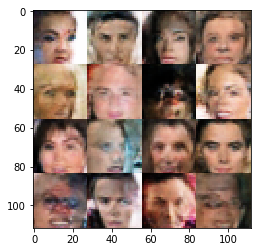

Epoch 0/1... Discriminator Loss: 0.8296... Generator Loss: 1.1240
Epoch 0/1... Discriminator Loss: 1.1744... Generator Loss: 0.6617
Epoch 0/1... Discriminator Loss: 1.3173... Generator Loss: 0.5831
Epoch 0/1... Discriminator Loss: 0.8979... Generator Loss: 1.4081
Epoch 0/1... Discriminator Loss: 1.5478... Generator Loss: 0.4365
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


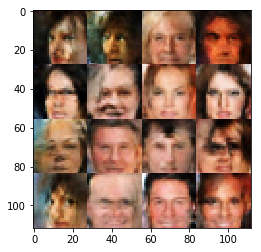

Epoch 0/1... Discriminator Loss: 0.9114... Generator Loss: 1.3063
Epoch 0/1... Discriminator Loss: 0.9185... Generator Loss: 1.1624
Epoch 0/1... Discriminator Loss: 0.8732... Generator Loss: 1.4647
Epoch 0/1... Discriminator Loss: 0.8354... Generator Loss: 1.4056
Epoch 0/1... Discriminator Loss: 1.0361... Generator Loss: 1.0589
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


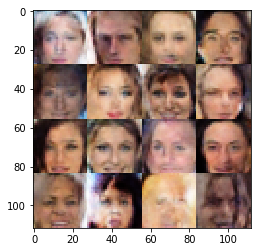

Epoch 0/1... Discriminator Loss: 1.1945... Generator Loss: 0.7148
Epoch 0/1... Discriminator Loss: 1.0121... Generator Loss: 0.9270
Epoch 0/1... Discriminator Loss: 1.1703... Generator Loss: 0.6701
Epoch 0/1... Discriminator Loss: 1.1461... Generator Loss: 1.1644
Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.6523
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


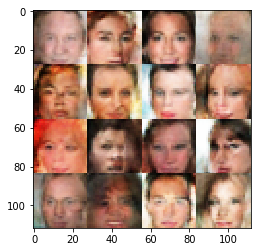

Epoch 0/1... Discriminator Loss: 0.9134... Generator Loss: 1.2183
Epoch 0/1... Discriminator Loss: 0.8696... Generator Loss: 1.1696
Epoch 0/1... Discriminator Loss: 0.9599... Generator Loss: 0.8840
Epoch 0/1... Discriminator Loss: 1.0574... Generator Loss: 1.2401
Epoch 0/1... Discriminator Loss: 1.2250... Generator Loss: 0.5364
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


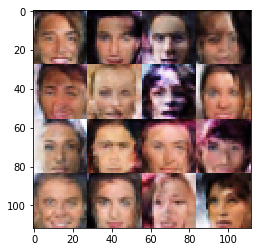

Epoch 0/1... Discriminator Loss: 1.5021... Generator Loss: 0.5656
Epoch 0/1... Discriminator Loss: 0.8422... Generator Loss: 1.1316
Epoch 0/1... Discriminator Loss: 0.9031... Generator Loss: 1.3456
Epoch 0/1... Discriminator Loss: 1.1153... Generator Loss: 1.0847
Epoch 0/1... Discriminator Loss: 0.9186... Generator Loss: 1.0988
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


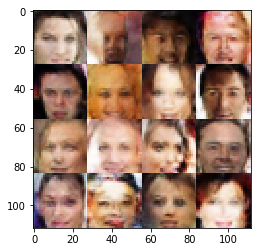

Epoch 0/1... Discriminator Loss: 1.1165... Generator Loss: 1.1411
Epoch 0/1... Discriminator Loss: 1.6798... Generator Loss: 0.3780
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.7259
Epoch 0/1... Discriminator Loss: 1.0393... Generator Loss: 0.8599
Epoch 0/1... Discriminator Loss: 0.9861... Generator Loss: 1.0054
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


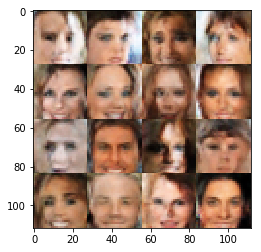

Epoch 0/1... Discriminator Loss: 0.9891... Generator Loss: 0.8221
Epoch 0/1... Discriminator Loss: 0.9267... Generator Loss: 0.8491
Epoch 0/1... Discriminator Loss: 1.3240... Generator Loss: 0.5590
Epoch 0/1... Discriminator Loss: 1.0198... Generator Loss: 1.0871
Epoch 0/1... Discriminator Loss: 0.7912... Generator Loss: 1.4879
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


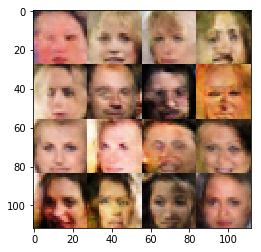

Epoch 0/1... Discriminator Loss: 0.9472... Generator Loss: 0.9793
Epoch 0/1... Discriminator Loss: 1.2400... Generator Loss: 0.7017
Epoch 0/1... Discriminator Loss: 1.4526... Generator Loss: 0.5307
Epoch 0/1... Discriminator Loss: 0.9170... Generator Loss: 1.4561
Epoch 0/1... Discriminator Loss: 0.6113... Generator Loss: 1.6362
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


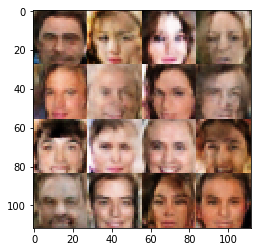

Epoch 0/1... Discriminator Loss: 1.0311... Generator Loss: 0.9950
Epoch 0/1... Discriminator Loss: 1.0853... Generator Loss: 0.8454
Epoch 0/1... Discriminator Loss: 0.9259... Generator Loss: 1.0341
Epoch 0/1... Discriminator Loss: 1.0020... Generator Loss: 1.0692
Epoch 0/1... Discriminator Loss: 1.2584... Generator Loss: 0.5382
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


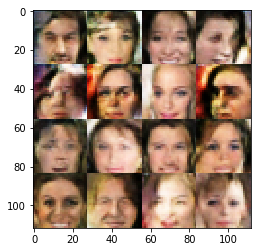

Epoch 0/1... Discriminator Loss: 1.0699... Generator Loss: 0.9713
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.9709
Epoch 0/1... Discriminator Loss: 0.9973... Generator Loss: 0.9534
Epoch 0/1... Discriminator Loss: 1.1957... Generator Loss: 0.6406
Epoch 0/1... Discriminator Loss: 0.9411... Generator Loss: 1.3462
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


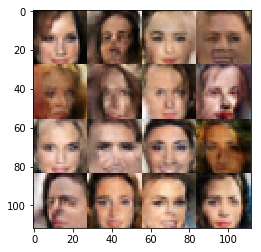

Epoch 0/1... Discriminator Loss: 0.9327... Generator Loss: 1.1208
Epoch 0/1... Discriminator Loss: 0.9099... Generator Loss: 0.9440
Epoch 0/1... Discriminator Loss: 1.0091... Generator Loss: 0.9163
Epoch 0/1... Discriminator Loss: 1.0177... Generator Loss: 0.8397
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 0.6440
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


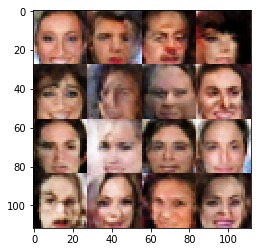

Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 1.1069
Epoch 0/1... Discriminator Loss: 0.9048... Generator Loss: 1.4742
Epoch 0/1... Discriminator Loss: 0.8547... Generator Loss: 1.2204
Epoch 0/1... Discriminator Loss: 1.0355... Generator Loss: 0.7863
Epoch 0/1... Discriminator Loss: 0.9400... Generator Loss: 1.0578
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


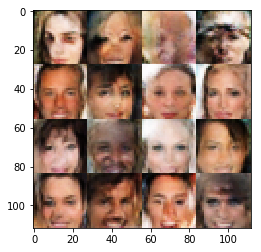

Epoch 0/1... Discriminator Loss: 1.1584... Generator Loss: 0.7531
Epoch 0/1... Discriminator Loss: 0.9760... Generator Loss: 0.9278
Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.8793
Epoch 0/1... Discriminator Loss: 1.2597... Generator Loss: 2.2005
Epoch 0/1... Discriminator Loss: 1.1413... Generator Loss: 0.7050
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


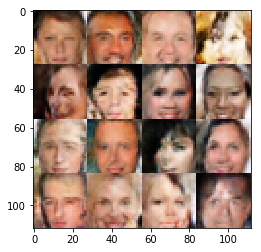

Epoch 0/1... Discriminator Loss: 0.9358... Generator Loss: 0.9837
Epoch 0/1... Discriminator Loss: 1.0812... Generator Loss: 1.1528
Epoch 0/1... Discriminator Loss: 0.9672... Generator Loss: 0.8857
Epoch 0/1... Discriminator Loss: 0.9843... Generator Loss: 1.1807
Epoch 0/1... Discriminator Loss: 1.1143... Generator Loss: 0.8004
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


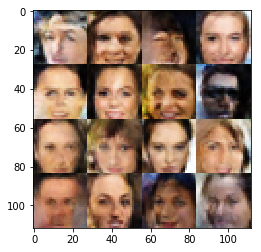

Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 1.4893
Epoch 0/1... Discriminator Loss: 0.8626... Generator Loss: 1.1998
Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 1.1272
Epoch 0/1... Discriminator Loss: 1.0160... Generator Loss: 1.0319
Epoch 0/1... Discriminator Loss: 0.9727... Generator Loss: 1.0144
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


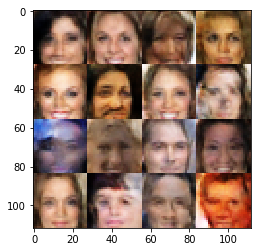

Epoch 0/1... Discriminator Loss: 0.8795... Generator Loss: 1.0921
Epoch 0/1... Discriminator Loss: 0.9857... Generator Loss: 1.2088
Epoch 0/1... Discriminator Loss: 0.8202... Generator Loss: 1.7873
Epoch 0/1... Discriminator Loss: 0.7837... Generator Loss: 1.2489
Epoch 0/1... Discriminator Loss: 1.1488... Generator Loss: 0.8549
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


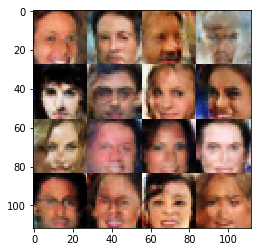

Epoch 0/1... Discriminator Loss: 0.9838... Generator Loss: 0.7896
Epoch 0/1... Discriminator Loss: 0.9653... Generator Loss: 0.9414
Epoch 0/1... Discriminator Loss: 1.0323... Generator Loss: 1.1908
Epoch 0/1... Discriminator Loss: 0.8775... Generator Loss: 1.2795
Epoch 0/1... Discriminator Loss: 0.9573... Generator Loss: 1.0930
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


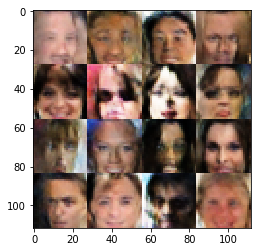

Epoch 0/1... Discriminator Loss: 1.0501... Generator Loss: 0.8273
Epoch 0/1... Discriminator Loss: 1.0083... Generator Loss: 0.9734
Epoch 0/1... Discriminator Loss: 0.9341... Generator Loss: 1.2099
Epoch 0/1... Discriminator Loss: 1.0502... Generator Loss: 0.7663
Epoch 0/1... Discriminator Loss: 1.1208... Generator Loss: 0.6204
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


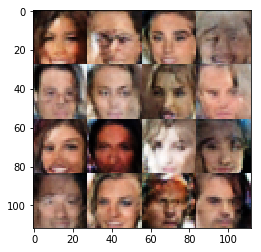

Epoch 0/1... Discriminator Loss: 1.1390... Generator Loss: 0.7548
Epoch 0/1... Discriminator Loss: 1.4680... Generator Loss: 0.4744
Epoch 0/1... Discriminator Loss: 1.2138... Generator Loss: 0.6446
Epoch 0/1... Discriminator Loss: 0.8906... Generator Loss: 1.4575
Epoch 0/1... Discriminator Loss: 1.1197... Generator Loss: 1.1772
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


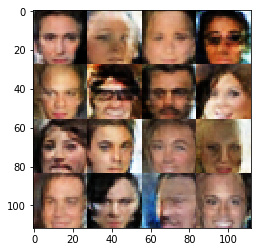

Epoch 0/1... Discriminator Loss: 0.9310... Generator Loss: 1.1527
Epoch 0/1... Discriminator Loss: 0.9455... Generator Loss: 1.1036
Epoch 0/1... Discriminator Loss: 1.0481... Generator Loss: 1.0487
Epoch 0/1... Discriminator Loss: 0.8641... Generator Loss: 1.1822
Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 0.7236
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


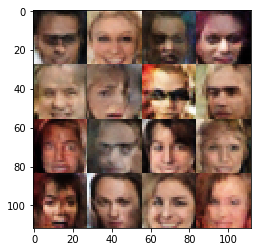

Epoch 0/1... Discriminator Loss: 0.8682... Generator Loss: 1.3255
Epoch 0/1... Discriminator Loss: 1.5184... Generator Loss: 0.4868
Epoch 0/1... Discriminator Loss: 0.9954... Generator Loss: 0.8583
Epoch 0/1... Discriminator Loss: 1.0051... Generator Loss: 0.9969
Epoch 0/1... Discriminator Loss: 0.8059... Generator Loss: 1.3453
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


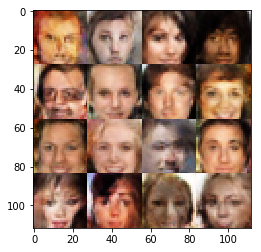

Epoch 0/1... Discriminator Loss: 0.8439... Generator Loss: 1.2119
Epoch 0/1... Discriminator Loss: 0.9127... Generator Loss: 1.1858
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 0.9942
Epoch 0/1... Discriminator Loss: 0.8125... Generator Loss: 1.1587
Epoch 0/1... Discriminator Loss: 0.8822... Generator Loss: 1.1135
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


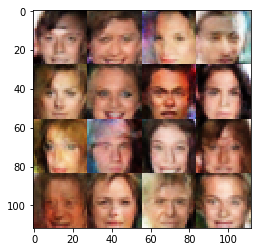

Epoch 0/1... Discriminator Loss: 1.0596... Generator Loss: 1.0188
Epoch 0/1... Discriminator Loss: 1.2062... Generator Loss: 0.7406
Epoch 0/1... Discriminator Loss: 1.2650... Generator Loss: 0.5979
Epoch 0/1... Discriminator Loss: 1.0341... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 1.0836... Generator Loss: 0.7736
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


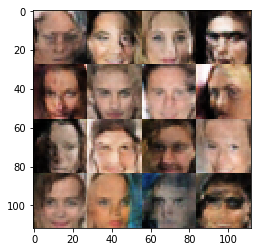

Epoch 0/1... Discriminator Loss: 1.0001... Generator Loss: 1.1765
Epoch 0/1... Discriminator Loss: 0.8938... Generator Loss: 1.5924
Epoch 0/1... Discriminator Loss: 1.2098... Generator Loss: 0.7548
Epoch 0/1... Discriminator Loss: 0.9457... Generator Loss: 1.3441
Epoch 0/1... Discriminator Loss: 1.0582... Generator Loss: 0.8085
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


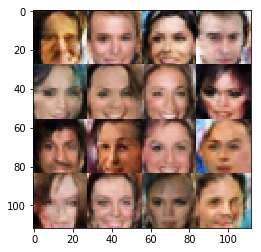

Epoch 0/1... Discriminator Loss: 0.9586... Generator Loss: 0.9255
Epoch 0/1... Discriminator Loss: 0.8589... Generator Loss: 1.3269
Epoch 0/1... Discriminator Loss: 0.9753... Generator Loss: 1.4805
Epoch 0/1... Discriminator Loss: 0.8515... Generator Loss: 1.3544
Epoch 0/1... Discriminator Loss: 1.2123... Generator Loss: 0.5733
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


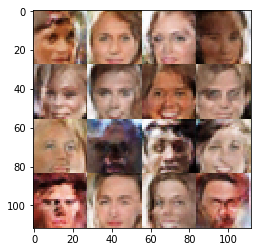

Epoch 0/1... Discriminator Loss: 1.3009... Generator Loss: 0.6458
Epoch 0/1... Discriminator Loss: 1.0247... Generator Loss: 0.8766
Epoch 0/1... Discriminator Loss: 0.9566... Generator Loss: 1.3645
Epoch 0/1... Discriminator Loss: 1.0154... Generator Loss: 0.7338
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 1.0029
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


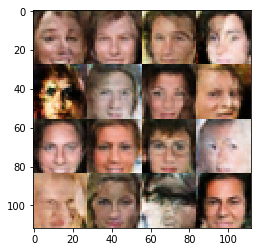

Epoch 0/1... Discriminator Loss: 1.3464... Generator Loss: 0.6680
Epoch 0/1... Discriminator Loss: 0.9092... Generator Loss: 1.0486
Epoch 0/1... Discriminator Loss: 0.9625... Generator Loss: 1.6276
Epoch 0/1... Discriminator Loss: 1.0947... Generator Loss: 0.8638
Epoch 0/1... Discriminator Loss: 1.0193... Generator Loss: 0.8402
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


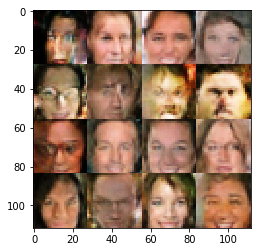

Epoch 0/1... Discriminator Loss: 0.9391... Generator Loss: 1.4422
Epoch 0/1... Discriminator Loss: 1.0403... Generator Loss: 1.0036
Epoch 0/1... Discriminator Loss: 0.8669... Generator Loss: 1.2079
Epoch 0/1... Discriminator Loss: 0.9714... Generator Loss: 1.4244
Epoch 0/1... Discriminator Loss: 1.0249... Generator Loss: 1.0076
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


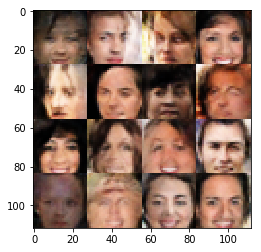

Epoch 0/1... Discriminator Loss: 1.1675... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 0.8949... Generator Loss: 1.0608
Epoch 0/1... Discriminator Loss: 0.8166... Generator Loss: 1.1625
Epoch 0/1... Discriminator Loss: 0.9728... Generator Loss: 1.4797
Epoch 0/1... Discriminator Loss: 1.2429... Generator Loss: 0.6814
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


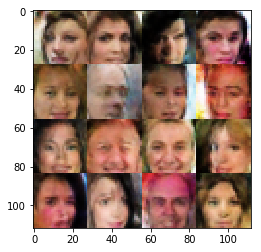

Epoch 0/1... Discriminator Loss: 0.9610... Generator Loss: 1.1466
Epoch 0/1... Discriminator Loss: 0.8975... Generator Loss: 0.9972
Epoch 0/1... Discriminator Loss: 0.7499... Generator Loss: 1.2873
Epoch 0/1... Discriminator Loss: 1.0295... Generator Loss: 1.4680
Epoch 0/1... Discriminator Loss: 0.9756... Generator Loss: 0.8540
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


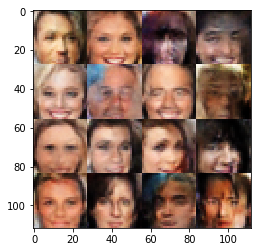

Epoch 0/1... Discriminator Loss: 0.8147... Generator Loss: 1.3011
Epoch 0/1... Discriminator Loss: 1.1492... Generator Loss: 1.0096
Epoch 0/1... Discriminator Loss: 0.9247... Generator Loss: 1.0993
Epoch 0/1... Discriminator Loss: 0.8326... Generator Loss: 2.0543
Epoch 0/1... Discriminator Loss: 0.8354... Generator Loss: 1.2769
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


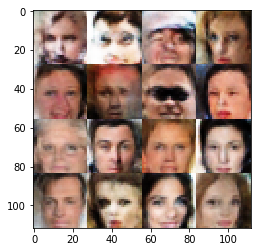

Epoch 0/1... Discriminator Loss: 0.8590... Generator Loss: 1.3396
Epoch 0/1... Discriminator Loss: 1.2392... Generator Loss: 0.8304
Epoch 0/1... Discriminator Loss: 0.9756... Generator Loss: 0.9446
Epoch 0/1... Discriminator Loss: 0.8731... Generator Loss: 1.1564
Epoch 0/1... Discriminator Loss: 1.1295... Generator Loss: 0.9680
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


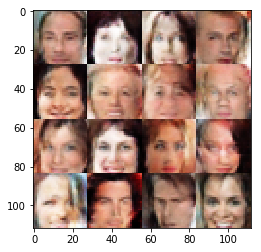

Epoch 0/1... Discriminator Loss: 0.8875... Generator Loss: 1.1004
Epoch 0/1... Discriminator Loss: 0.9217... Generator Loss: 0.9831
Epoch 0/1... Discriminator Loss: 1.6123... Generator Loss: 0.3910
Epoch 0/1... Discriminator Loss: 1.1849... Generator Loss: 1.1997
Epoch 0/1... Discriminator Loss: 0.8911... Generator Loss: 1.0342
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


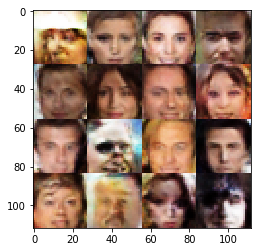

Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 1.5466
Epoch 0/1... Discriminator Loss: 0.7780... Generator Loss: 2.0487
Epoch 0/1... Discriminator Loss: 1.0338... Generator Loss: 0.7844
Epoch 0/1... Discriminator Loss: 0.8709... Generator Loss: 1.2137
Epoch 0/1... Discriminator Loss: 0.9286... Generator Loss: 1.1650
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


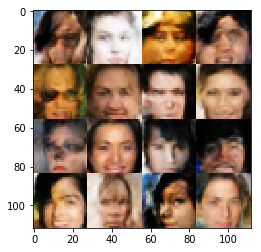

Epoch 0/1... Discriminator Loss: 0.8802... Generator Loss: 1.2723
Epoch 0/1... Discriminator Loss: 0.7609... Generator Loss: 1.4013
Epoch 0/1... Discriminator Loss: 0.7482... Generator Loss: 1.4195
Epoch 0/1... Discriminator Loss: 1.1241... Generator Loss: 0.8038
Epoch 0/1... Discriminator Loss: 0.9133... Generator Loss: 1.3589
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


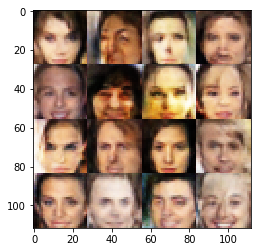

Epoch 0/1... Discriminator Loss: 0.9138... Generator Loss: 1.0575
Epoch 0/1... Discriminator Loss: 1.1152... Generator Loss: 0.6743
Epoch 0/1... Discriminator Loss: 1.2739... Generator Loss: 0.8925
Epoch 0/1... Discriminator Loss: 0.8362... Generator Loss: 1.4115
Epoch 0/1... Discriminator Loss: 0.7942... Generator Loss: 1.0764
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


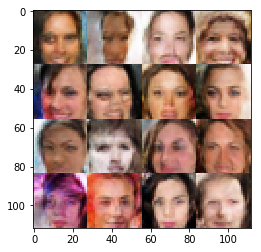

Epoch 0/1... Discriminator Loss: 1.3532... Generator Loss: 0.5576
Epoch 0/1... Discriminator Loss: 1.3895... Generator Loss: 0.5215
Epoch 0/1... Discriminator Loss: 1.0096... Generator Loss: 1.2396
Epoch 0/1... Discriminator Loss: 1.0117... Generator Loss: 0.9086
Epoch 0/1... Discriminator Loss: 0.8144... Generator Loss: 1.6524
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


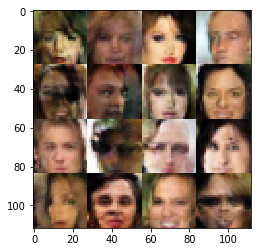

Epoch 0/1... Discriminator Loss: 0.9669... Generator Loss: 1.0667
Epoch 0/1... Discriminator Loss: 1.0825... Generator Loss: 0.8412
Epoch 0/1... Discriminator Loss: 0.8800... Generator Loss: 1.2404
Epoch 0/1... Discriminator Loss: 0.8222... Generator Loss: 1.2109
Epoch 0/1... Discriminator Loss: 1.3017... Generator Loss: 0.5769
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


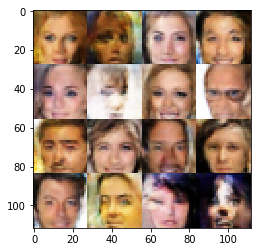

Epoch 0/1... Discriminator Loss: 0.8939... Generator Loss: 1.4951
Epoch 0/1... Discriminator Loss: 1.0765... Generator Loss: 0.8037
Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 0.8530
Epoch 0/1... Discriminator Loss: 0.7622... Generator Loss: 1.6654
Epoch 0/1... Discriminator Loss: 1.2550... Generator Loss: 0.7457
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


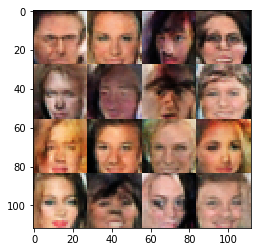

Epoch 0/1... Discriminator Loss: 0.9125... Generator Loss: 0.9915
Epoch 0/1... Discriminator Loss: 0.8576... Generator Loss: 1.3979
Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 0.8693
Epoch 0/1... Discriminator Loss: 1.2102... Generator Loss: 0.7158
Epoch 0/1... Discriminator Loss: 0.9786... Generator Loss: 0.8854
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


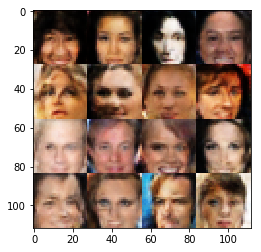

Epoch 0/1... Discriminator Loss: 0.8914... Generator Loss: 2.0005
Epoch 0/1... Discriminator Loss: 1.2482... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.1875... Generator Loss: 0.7847
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 1.0414
Epoch 0/1... Discriminator Loss: 0.8494... Generator Loss: 1.0973
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


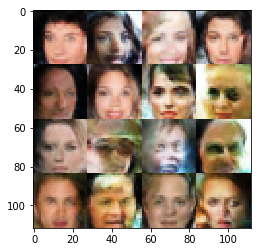

Epoch 0/1... Discriminator Loss: 1.3240... Generator Loss: 0.6206
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 0.9200
Epoch 0/1... Discriminator Loss: 1.3320... Generator Loss: 0.5301
Epoch 0/1... Discriminator Loss: 0.9918... Generator Loss: 1.0588
Epoch 0/1... Discriminator Loss: 0.8448... Generator Loss: 0.9876
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


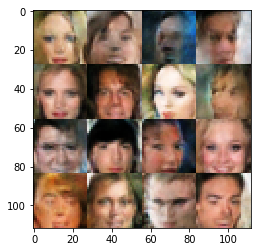

Epoch 0/1... Discriminator Loss: 1.0993... Generator Loss: 0.7550
Epoch 0/1... Discriminator Loss: 1.0308... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 0.9567... Generator Loss: 1.0762
Epoch 0/1... Discriminator Loss: 0.8318... Generator Loss: 1.1517
Epoch 0/1... Discriminator Loss: 0.9829... Generator Loss: 0.9083
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


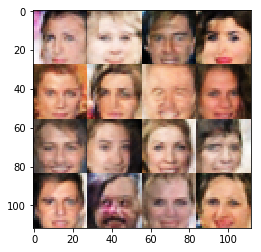

Epoch 0/1... Discriminator Loss: 1.1664... Generator Loss: 0.7320
Epoch 0/1... Discriminator Loss: 0.7949... Generator Loss: 1.4232
Epoch 0/1... Discriminator Loss: 1.1817... Generator Loss: 0.7502
Epoch 0/1... Discriminator Loss: 0.9686... Generator Loss: 0.9250
CPU times: user 12min 34s, sys: 1min 50s, total: 14min 25s
Wall time: 22min 49s


In [28]:
%%time
batch_size = 32
z_dim = 130
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("finished loading images.")

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.